In [35]:
# 경고(warning) 비표시
import warnings
warnings.filterwarnings('ignore')

# 고객 행동 예측

### 1 : 데이터 읽고 확인

In [36]:
import pandas as pd

In [37]:
customer_join = pd.read_csv('./data/customer_join.csv')

customer_join.head()

# customer_join.isnull().sum()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [38]:
use_log_months = pd.read_csv('./data/use_log_months.csv')

use_log_months.head()

use_log_months.isnull().sum()

연월             0
customer_id    0
count          0
dtype: int64

In [39]:
use_log = pd.read_csv('./data/use_log.csv')

use_log.head()

use_log.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

### 2 : 클러스터링으로 회원 그룹화

In [40]:
# mean, median, max, min : 월 이용 횟수, 1~8
# membership_period : 기간, 최댓값 (47)
# 표준화 : StandardScaler()
# 필드 추출 , K-means 알고리즘 사용 (클러스터 개수: 4개)

In [41]:
customer_clustering = customer_join[['mean','median','max','min','membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 표준화
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

# k-means 
kmeans = KMeans(n_clusters=4,random_state=0)
clusters = kmeans.fit(customer_clustering_sc)

# 클러스터링 결과
customer_clustering['cluster'] = clusters.labels_
print(customer_clustering['cluster'].unique)
customer_clustering.head()



<bound method Series.unique of 0       3
1       3
2       3
3       3
4       3
       ..
4187    2
4188    2
4189    2
4190    2
4191    2
Name: cluster, Length: 4192, dtype: int32>


,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


In [45]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans

# # Assuming customer_clustering is a DataFrame

# # 표준화
# sc = StandardScaler()
# customer_clustering_sc = sc.fit_transform(customer_clustering)

# # k-means 
# kmeans = KMeans(n_clusters=4, random_state=0)
# clusters = kmeans.fit_predict(customer_clustering_sc)

# # 클러스터링 결과를 DataFrame에 추가
# customer_clustering['cluster'] = clusters

# # 각 클러스터 라벨의 유일한 값 출력
# print(customer_clustering['cluster'].unique())

# # 데이터프레임의 처음 부분 출력
# customer_clustering.head()


[1 2 0 3]


,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


### 3 : 클러스터링 결과 분석

In [48]:
customer_clustering.columns = ['월평균값','월중앙값','월최댓값','월최솟값','회원기간','cluster']
customer_clustering.groupby('cluster').count()




,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,1334,1334,1334,1334,1334
1,763,763,763,763,763
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


In [49]:
# 그룹별 평균값 출력
customer_clustering.groupby('cluster').mean()
# 그룹3은 회원기간은 짧지만 이용률이 높은 회원임

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,3.054713,2.888598,4.756225,1.653997,9.263434
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


### 4 : 클러스터링 결과 가시화

In [51]:
# 주성분 분석
from sklearn.decomposition import PCA # 데이터의 차원을 줄이는데 사용

X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)

# 2차원으로 축소한 데이터, 클러스터링 결과 저장
pca_df =pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']
pca_df

,0,1,cluster
0,-0.905588,-1.337020,3
1,-0.778410,-1.091018,3
2,-1.110240,-0.849057,3
3,-1.225264,-1.097134,3
4,-2.052122,-0.845202,3
...,...,...,...
4187,3.376510,1.574791,2
4188,5.343139,0.962464,2
4189,3.376510,1.574791,2
4190,6.326454,0.656301,2


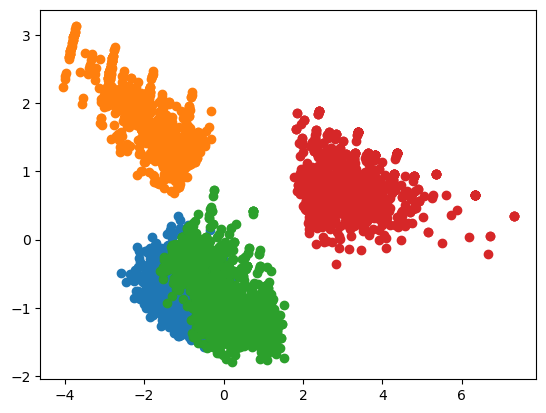

In [52]:
import matplotlib.pyplot as plt

for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster']==i]
    plt.scatter(tmp[0],tmp[1])

### 5 : 클러스터링 결과를 바탕으로 탈퇴회원 경향 파악

In [53]:
# 4개의 그룹에서 지속 회원과 탈퇴 회원이 얼마나 있을까?
# 지속회원과 탈퇴 회원을 집계 : is_deleted


# customer_clustering, customer 결합
customer_clustering = pd.concat([customer_clustering, customer_join], axis=1)
# 탈퇴 회원 특정
customer_clustering.groupby(["cluster", "is_deleted"], as_index=False).count()[["cluster", "is_deleted", "customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,1,763
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


### 6 : 다음달의 이용횟수 예측을 위해 테이터 준비

### 7 : 특징이 되는 변수 추가

### 8 : 다음달 이용횟수를 예측하는 모델 구축

### 9 : 모델에 기여하는 변수 확인

### 10: 다음달의 이용횟수 예측